In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from scipy import stats
import pickle

import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger') 
nltk.download('omw-1.4')

# from nltk.tokenize import word_tokenize
# from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from wordcloud import WordCloud

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Dense,SpatialDropout1D

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn
import pickle

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [74]:
df = pd.read_csv('/content/drive/My Drive/Hate_speech/train_tweets.csv')
df

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
...,...,...,...
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."


In [75]:
df.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [76]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

In [77]:
stopwords = nltk.corpus.stopwords.words("english")

def clean_txt(tweet):
    
    # removal of extra spaces
    regex_pat = re.compile(r'\s+')
    Tweet = re.sub(regex_pat," ",tweet)
    
    #Remove @tags
    Tweet= re.sub(r'@[\w\-]+',"",Tweet)
    
    # removal of links[https://abc.com]
    url_regex =  re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
            '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    Tweet = re.sub(url_regex,"",Tweet)
    
    # split into words (tokenizing)
    Tweet = nltk.word_tokenize(Tweet)
    
    # convert to lower case
    Tweet = [w.lower() for w in Tweet]    
    
    # remove punctuation from each word
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    Tweet = [re_punc.sub('', w) for w in Tweet]

    # remove remaining tokens that are not alphabetic
    Tweet = [word for word in Tweet if word.isalpha()]

    # filter out stop words
    Tweet = [w for w in Tweet if w not in  stopwords] 
    
    # filter out short tokens
    Tweet = [word for word in Tweet if len(word) > 2]

    #Stemm all the words in the sentence
    lemmatizer = WordNetLemmatizer() 
    lem_words = [lemmatizer.lemmatize(word) for word in Tweet]
    combined_text = ' '.join(lem_words)
    return combined_text

# Cleaning the text data
df['cleaned_phrase'] = df['tweet'].apply(clean_txt)
df.sample(10)

,id,label,tweet,cleaned_phrase
10310,10311,0,making a story with 52 characters each represe...,making story character representing card deck ...
14295,14296,0,lt. gov. cox @user speaks at vigil for orlando...,gov cox speaks vigil orlando hea changed leade...
11943,11944,1,@user you might be a libtard if... #libtard #...,might libtard libtard sjw liberal politics
31107,31108,0,exactly my thoughts. teens poems ness quote...,exactly thought teen poem ness quote alone
2565,2566,0,#opi gorilla simulator: you need to do to ad...,opi gorilla simulator need adapt environment n...
5008,5009,0,@user really needs to train their aist better ...,really need train aist better order side peppe...
2511,2512,0,ready for b-fest!!!! #bfestbuzz #bnmidwest,ready bfest bfestbuzz bnmidwest
5513,5514,0,"now playing : joe bongiorno - "" into the win...",playing joe bongiorno wind music song
25954,25955,0,pray for orlando .... stay close to god always.,pray orlando stay close god always
22515,22516,0,@user #lawofattraction for #healing #loa be...,lawofattraction healing loa healthy well idwp


In [78]:
cleaned_phrase_list = df.cleaned_phrase.values.tolist()

In [79]:
Y = df.label.to_numpy()
Y

array([0, 0, 0, ..., 0, 1, 0])

In [80]:
#tokenization
max_words = 10000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(cleaned_phrase_list)
sequences = tok.texts_to_sequences(cleaned_phrase_list)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)
sequences_matrix

array([[   0,    0,    0, ...,  116, 6570,  306],
       [   0,    0,    0, ..., 3630, 6572, 8402],
       [   0,    0,    0, ...,    0,   17, 2812],
       ...,
       [   0,    0,    0, ..., 6355,   24,   59],
       [   0,    0,    0, ..., 1330, 1331,  421],
       [   0,    0,    0, ...,    0,   90,   99]], dtype=int32)

In [81]:
type(sequences_matrix)

numpy.ndarray

In [82]:
X=sequences_matrix

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.1, random_state = 1, shuffle=True)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28765, 150) (28765,)
(3197, 150) (3197,)


In [83]:
print(type(X_train))
print(type(Y_train))
print(type(X_test))
print(type(Y_test))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [84]:
# from tensorflow.keras.initializers import Constant
# from tensorflow.keras.optimizers import Adam


embedding_mat_col=512

# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=embedding_mat_col, input_length=max_len))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(50, dropout=0.4, recurrent_dropout=0.4,input_shape=(None, 512)))
# model.add(Dense(1,activation='softmax'))

# dropout=0.4, recurrent_dropout=0.4, 

model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_mat_col, input_length=max_len),
    tf.keras.layers.LSTM(20, input_shape=(None, 512)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 512)          5120000   
                                                                 
 lstm_4 (LSTM)               (None, 20)                42640     
                                                                 
 batch_normalization_4 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_12 (Dense)            (None, 8)                 168       
                                                                 
 dense_13 (Dense)            (None, 4)                 36        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                      

In [85]:
batch_size =32
model.fit(X_train, Y_train, epochs = 5, batch_size=batch_size,verbose = 2)

pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/model_LSTM.pkl','wb'))

model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/model_LSTM.pkl','rb'))

Epoch 1/5
899/899 - 152s - loss: 0.1616 - accuracy: 0.9502 - 152s/epoch - 169ms/step
Epoch 2/5
899/899 - 140s - loss: 0.0706 - accuracy: 0.9747 - 140s/epoch - 156ms/step
Epoch 3/5
899/899 - 138s - loss: 0.0397 - accuracy: 0.9850 - 138s/epoch - 154ms/step
Epoch 4/5
899/899 - 137s - loss: 0.0259 - accuracy: 0.9905 - 137s/epoch - 153ms/step
Epoch 5/5
899/899 - 135s - loss: 0.0187 - accuracy: 0.9925 - 135s/epoch - 150ms/step


In [86]:
model.evaluate(X_test, Y_test)

100/100 [==============================] - 3s 24ms/step - loss: 0.2440 - accuracy: 0.9531


[0.24404242634773254, 0.9530810117721558]

In [87]:
prediction=model.predict(X_test)
prediction = prediction.flatten()

100/100 [==============================] - 3s 25ms/step


In [90]:
import numpy as np

prediction = np.where(prediction > 0.5, 1, 0)
prediction

array([0, 0, 0, ..., 0, 0, 0])

In [91]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(Y_test, prediction)
cm 

array([[2911,   53],
       [  97,  136]])

Text(159.0, 0.5, 'Truth')

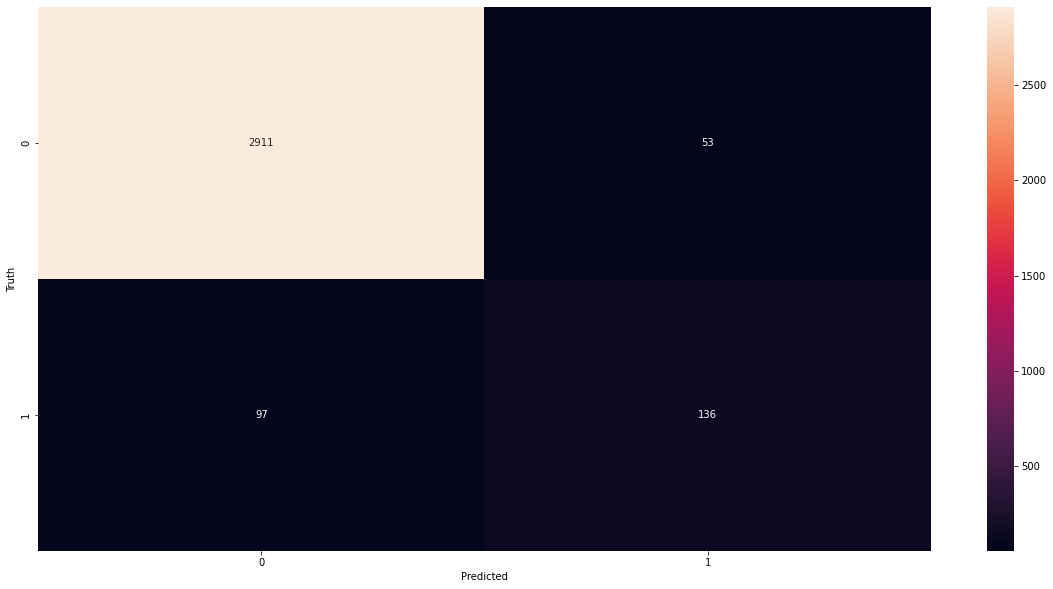

In [92]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [93]:
print(classification_report(Y_test, prediction))


              precision    recall  f1-score   support

           0       0.97      0.98      0.97      2964
           1       0.72      0.58      0.64       233

    accuracy                           0.95      3197
   macro avg       0.84      0.78      0.81      3197
weighted avg       0.95      0.95      0.95      3197



Balance the Dataset

In [94]:
from sklearn.utils import resample


X_wb=df['cleaned_phrase'].values
Y_wb=df['label'].values

X_wb_train, X_wb_test, Y_wb_train, Y_wb_test = train_test_split(X_wb, Y_wb, stratify=Y,test_size = 0.1, random_state = 1, shuffle=True)



def oversample(train_sample):
  """Oversample minoriity class because of the imbalance"""
  # Separate majority and minority classes in training data for oversampling
  train_majority = train_sample[train_sample['label'] == 0]
  train_minority = train_sample[train_sample['label'] == 1]

  print("majority class before oversample: ", train_majority.shape)
  print("minority class before oversample: ", train_minority.shape)

  # Upsample minority class
  train_minority_oversampled = resample(train_minority, 
                                 replace=True,      # sample with replacement
                                 n_samples= train_majority.shape[0],  # to match majority class
                                 random_state=123)  # reproducible results
 
  # Combine majority class with oversampled minority class
  train_oversampled = pd.concat([train_majority, train_minority_oversampled])
  # shuffling the data
  train_oversampled = train_oversampled.sample(frac=1).reset_index(drop=True)
  # Display new class counts
  print()
  print("After oversampling\n", train_oversampled.label.value_counts(), sep = "")
  return train_oversampled


train_over = oversample(pd.DataFrame({"tweet": X_wb_train, "label": Y_wb_train}))
Y_wb_train = train_over["label"].to_numpy()
X_wb_train = train_over["tweet"]
train_over

majority class before oversample:  (26747, 2)
minority class before oversample:  (2018, 2)

After oversampling
1    26747
0    26747
Name: label, dtype: int64


,tweet,label
0,okay course traitor bully notmypres,1
1,fuck donald trump never president opkkk optrum...,1
2,ifidontgetmyfirstchoice huff puff tweet little...,0
3,wonderful love emikagifts jewelrydesign designer,0
4,friday say picture,0
...,...,...
53489,ppl try find look laughing confused gamergirl ...,0
53490,black amp feel like stomping listen retweet tampa,1
53491,scottbrownvshyperbassweredroppinthis web hardcore,0
53492,po take painting asshole fucking chump,1


In [95]:
clean_text = train_over.tweet.values.tolist()

In [96]:
max_words = 10000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(clean_text)
seq = tok.texts_to_sequences(clean_text)
seq_matrix = pad_sequences(seq,maxlen=max_len)
seq_matrix

array([[   0,    0,    0, ...,  603, 1080, 1166],
       [   0,    0,    0, ..., 5641, 5642, 4816],
       [   0,    0,    0, ..., 1636, 1849, 6471],
       ...,
       [   0,    0,    0, ...,    0, 1855,  962],
       [   0,    0,    0, ...,  531,  313, 2454],
       [   0,    0,    0, ...,   71,   42,   40]], dtype=int32)

In [97]:
x = seq_matrix
y = train_over['label'].to_numpy()

In [98]:
print(type(x))
print(type(y))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [99]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.1, random_state = 1, shuffle=True)
print(x_train.shape,y_train.shape)
print(x_test.shape,y_test.shape)

(48144, 150) (48144,)
(5350, 150) (5350,)


In [100]:
embedding_mat_col=512

# model = Sequential()
# model.add(Embedding(input_dim=max_words, output_dim=embedding_mat_col, input_length=max_len))
# model.add(SpatialDropout1D(0.4))
# model.add(LSTM(50, dropout=0.4, recurrent_dropout=0.4,input_shape=(None, 512)))
# model.add(Dense(1,activation='softmax'))

# dropout=0.4, recurrent_dropout=0.4, 

model_wb = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=max_words, output_dim=embedding_mat_col, input_length=max_len),
    tf.keras.layers.LSTM(20, input_shape=(None, 512)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

model_wb.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_wb.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 512)          5120000   
                                                                 
 lstm_5 (LSTM)               (None, 20)                42640     
                                                                 
 batch_normalization_5 (Batc  (None, 20)               80        
 hNormalization)                                                 
                                                                 
 dense_15 (Dense)            (None, 8)                 168       
                                                                 
 dense_16 (Dense)            (None, 4)                 36        
                                                                 
 dense_17 (Dense)            (None, 1)                 5         
                                                      

In [108]:
batch_size =32
model.fit(x_train, y_train, epochs = 5, batch_size=batch_size,verbose = 1)

pickle.dump(model, open('/content/drive/MyDrive/Colab Notebooks/model_LSTM_wb.pkl','wb'))

model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/model_LSTM_wb.pkl','rb'))

Epoch 1/5
1505/1505 [==============================] - 242s 159ms/step - loss: 0.2668 - accuracy: 0.9170
Epoch 2/5
1505/1505 [==============================] - 242s 161ms/step - loss: 0.0262 - accuracy: 0.9912
Epoch 3/5
1505/1505 [==============================] - 242s 161ms/step - loss: 0.0122 - accuracy: 0.9958
Epoch 4/5
1505/1505 [==============================] - 241s 160ms/step - loss: 0.0101 - accuracy: 0.9965
Epoch 5/5
1505/1505 [==============================] - 241s 160ms/step - loss: 0.0113 - accuracy: 0.9961


In [109]:
y_pred=model.predict(x_test)
y_pred = y_pred.flatten()

168/168 [==============================] - 5s 27ms/step


In [110]:
import numpy as np

y_pred = np.where(y_pred > 0.5, 1, 0)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [111]:
from sklearn.metrics import confusion_matrix, classification_report

cm_wb = confusion_matrix(y_test, y_pred)
cm_wb

array([[2672,   49],
       [  14, 2615]])

Text(159.0, 0.5, 'Truth')

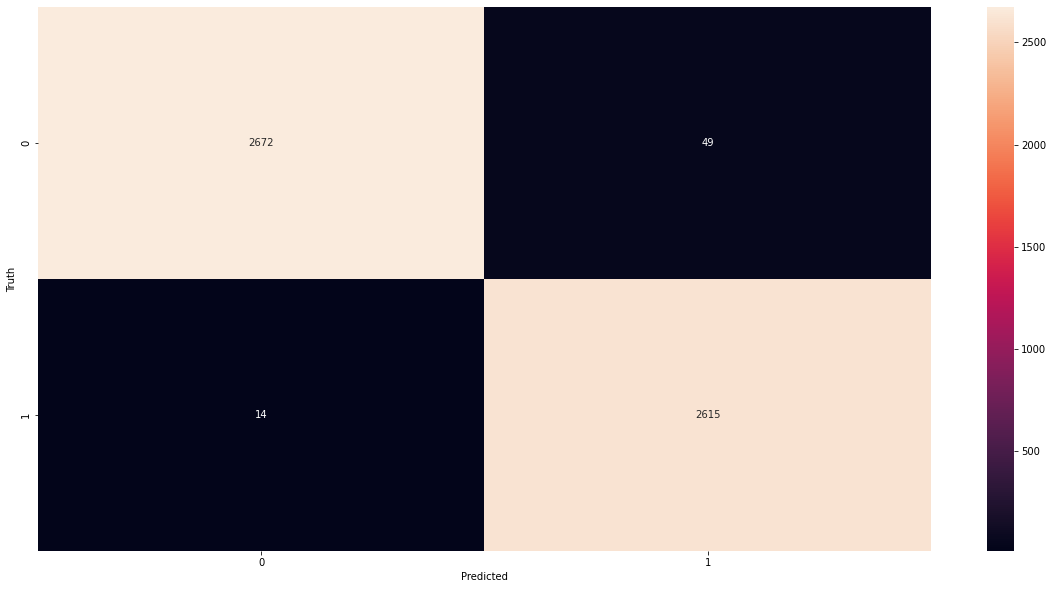

In [112]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm_wb, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [113]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2721
           1       0.98      0.99      0.99      2629

    accuracy                           0.99      5350
   macro avg       0.99      0.99      0.99      5350
weighted avg       0.99      0.99      0.99      5350

